In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# Preprocessing and Metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score,precision_recall_curve,f1_score, fbeta_score,\
                            accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report

# Modeling
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

# Other
from io import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image 
import pickle

# Load the data

Note: while cleaning and exploring the data, I had created 2 databases (df and df2), to use in modeling. I ran a logistic regression on both datasets and have only included the winning database below. The dataset below had a significantly better score. Additionally, I noted that the 'time to first funding' had a higher correlation with success than 'time between first and last funding'(as expected).

In [2]:
df = pd.read_pickle('Data/Processed Data/comps_with_founded_year.pkl')
len(df)

5968

# More Feature Engineering

Create dummy columns for top categories, countries, and states in the data.

In [4]:
# Create a list of the top categories, countries, and states and use them to create new  relative columns
top_categories = pd.read_pickle('Data/Processed Data/top_categories.pkl')
top_categories = top_categories['categories'].to_list()

top_countries = pd.read_pickle('Data/Processed Data/top_countries.pkl')
top_countries = top_countries['countries'].to_list()

top_USA_states = pd.read_pickle('Data/Processed Data/top_USA_states.pkl')
top_USA_states = top_USA_states['states'].to_list()

# Create a new column for the top categories in the data
df['category'] = df['category_list'].apply(lambda x: x if x in top_categories else 'other')
df['country'] = df['country_code'].apply( lambda x: x if x in top_countries else 'other')
df['state'] = df['state_code'].apply( lambda x: x if x in top_USA_states else 'other')

categories = pd.get_dummies(df['category'], drop_first=True)
countries = pd.get_dummies(df['country'], drop_first=True)
states = pd.get_dummies(df['state'])

df = pd.concat([df,categories], axis=1)
df = pd.concat([df,countries], axis=1)
df = pd.concat([df,states], axis=1)

# Check the data before modeling

In [5]:
df.sample(1)

,name,category_list,funding_total_usd,status,country_code,state_code,funding_rounds,founded_at,first_funding_at,last_funding_at,...,GBR,ISR,RUS,USA,other,CA,MA,NY,TX,other
6805,BillShrink,Curated Web,9000000,closed,USA,CA,2,2008-01-01,2007-07-30,2008-10-14,...,0,0,0,1,0,1,0,0,0,0


In [6]:
# Remove the columns not needed for modeling.
df.drop(['name', 'category_list', 'country_code', 'state_code', 'category', 'country', 'state',], 
        axis = 1, inplace= True)

In [7]:
df.isnull().sum()

funding_total_usd            0
status                       0
funding_rounds               0
founded_at                   0
first_funding_at             0
last_funding_at              0
first_funding_year           0
last_funding_year            0
months_bw_fundings           0
succeeded                    0
year_founded                 0
months_until_1st_fundings    0
Biotechnology                0
Clean Technology             0
Curated Web                  0
E-Commerce                   0
Enterprise Software          0
Games                        0
Hardware + Software          0
Mobile                       0
Security                     0
Social Media                 0
Software                     0
other                        0
FRA                          0
GBR                          0
ISR                          0
RUS                          0
USA                          0
other                        0
CA                           0
MA                           0
NY      

# Pair plot 
Inspect the pair plot for the relation between the Target and the non-categorical features.

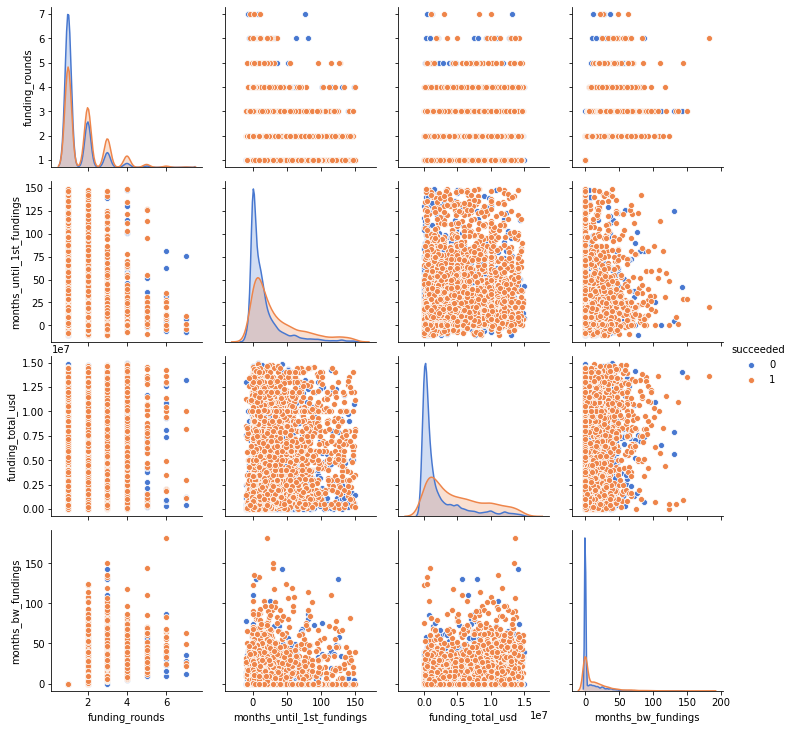

In [8]:
temp1 = df[['funding_rounds','months_until_1st_fundings','funding_total_usd','months_bw_fundings', 'succeeded']]
sns.pairplot(temp1, hue = 'succeeded', diag_kind="kde", palette='muted');

# Class imbalance
Let's look at the distribution of Target to see if class imbalance exists.

In [9]:
df['succeeded'].value_counts()

0    3465
1    2290
Name: succeeded, dtype: int64

**Conclusion**: The minority class (Target = 1) is ~ of 40% of total. SO the data is not very imbalanced.

In [10]:
# Define X and y and split the data into testing and training data.
# Multiple combination of features were test. This is the final X.
X = df[['funding_total_usd', 'funding_rounds', 'months_until_1st_fundings', 'months_bw_fundings',
        'Biotechnology', 'Clean Technology','Curated Web', 'E-Commerce', 'Enterprise Software', 'Games',
       'Hardware + Software', 'Mobile', 'Security', 'Social Media', 'Software',
        'FRA', 'GBR', 'ISR', 'RUS', 'USA', 'CA', 'MA', 'NY','TX'
       ]]
y = df['succeeded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [11]:
# Create a scaler to scale the data for models that need scaling.
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values), columns=X.columns)

In [36]:
# Instantiate a logistic regression model and put more weight on the minority class to deal with class imbalance
lg = LogisticRegression(C=10, solver='lbfgs')

# Metric
Using F2 as my main metric to place extra emphasis on recall to catch any potential “unicorns” even at the expense of investing in a few “duds”. This is of course subjective and a VC firm with lower risk tolerance may choose to place more emphasis on precision than recall.

In [37]:
# Function to calcluet fbeta
def calculate_fbeta(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    model.fit(X_train, y_train)
    
    fbeta_list=[]
    prob_theresholds = np.arange(0,1,.05)
    for prob in prob_theresholds:
        fbeta = fbeta_score(y_test, model.predict_proba(X_test)[:, 1] > prob, 2)
        fbeta_list.append(fbeta)
    fbeta = list(zip(prob_theresholds, fbeta_list)) 
    fbeta_best = max(fbeta, key=lambda x: x[1] )# key=lambda x: x[1] to do get the max on fbeta and not the threshold
    
    print('The probability threshold of {:6.4f} results in the best fbeta score: {:6.4f}.'.
        format(fbeta_best[0], fbeta_best[1]))
    return fbeta, fbeta_best

In [38]:
fbeta_lg, fbeta_best_lg = calculate_fbeta(lg, X_train=X_train_scaled, X_test=X_test_scaled)
p_thresh = fbeta_best_lg[0]

The probability threshold of 0.2000 results in the best fbeta score: 0.8040.


/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 

F2 score is good, but let's also look at the classification report and confusion matrix to make sure the model is doing a good job at predicting both classes.

In [18]:
pred = lg.predict_proba(X_test_scaled)[:, 1] > .2
print(confusion_matrix(y_test, pred))

[[358 658]
 [ 42 669]]


In [19]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.35      0.51      1016
           1       0.50      0.94      0.66       711

    accuracy                           0.59      1727
   macro avg       0.70      0.65      0.58      1727
weighted avg       0.73      0.59      0.57      1727



# Testing models and comparing results

The Logistic regression perform well but I still would like to look at test a few other classification algorithms to see if they perform better.

In [20]:
# Initiate the algorithms 
knn = KNeighborsClassifier()
svc = SVC(probability= True)
nb = BernoulliNB()
guass = GaussianNB()
dt = DecisionTreeClassifier(max_depth=5)
rf = RandomForestClassifier(n_estimators=10) 
xgb = XGBClassifier()

In [40]:
# Store their fbeta values for all the models defined above
# Scaling where needed: 
fbeta_knn, fbeta_best_knn = calculate_fbeta(knn, X_train=X_train_scaled, X_test=X_test_scaled)

fbeta_svc, fbeta_best_svc = calculate_fbeta(svc, X_train=X_train_scaled, X_test=X_test_scaled)

fbeta_nb, fbeta_best_nb = calculate_fbeta(nb, X_train=X_train_scaled, X_test=X_test_scaled)

fbeta_guass, fbeta_best_guass = calculate_fbeta(guass, X_train=X_train_scaled, X_test=X_test_scaled)

fbeta_dt, fbeta_best_dt = calculate_fbeta(dt)

fbeta_rf, fbeta_best_rf = calculate_fbeta(rf)

fbeta_xgb, fbeta_best_xgb = calculate_fbeta(xgb)

/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 

/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 

/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 

/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 

In [41]:
# Calculate ROC Score and AUC for all the models defined above.

# Logistic Regression
fpr_lg, tpr_lg, thresholds_lg = roc_curve( y_test,
                                           lg.predict_proba(X_test_scaled)[:, 1])  
auc_lg = roc_auc_score(y_test,
                       lg.predict_proba(X_test_scaled)[:, 1])  

# Knn
fpr_knn, tpr_knn, thresholds_knn = roc_curve( y_test,
                                           knn.predict_proba(X_test_scaled)[:, 1])  
auc_knn = roc_auc_score(y_test,
                       knn.predict_proba(X_test_scaled)[:, 1])  

# SVC
fpr_svc, tpr_svc, thresholds_svc = roc_curve( y_test,
                                           svc.predict_proba(X_test_scaled)[:, 1])  
auc_svc = roc_auc_score(y_test,
                       svc.predict_proba(X_test_scaled)[:, 1])  

# Bernoulli Naive Bayes
fpr_nb, tpr_nb, thresholds_nb = roc_curve( y_test,
                                           nb.predict_proba(X_test_scaled)[:, 1])  
auc_nb = roc_auc_score(y_test,
                       nb.predict_proba(X_test_scaled)[:, 1])  

# Gaussian Regression
fpr_guass, tpr_guass, thresholds_guass = roc_curve( y_test,
                                           guass.predict_proba(X_test_scaled)[:, 1])  
auc_guass = roc_auc_score(y_test,
                       guass.predict_proba(X_test_scaled)[:, 1])  

# Decision Tree
fpr_dt, tpr_dt, thresholds_dt = roc_curve( y_test,
                                           dt.predict_proba(X_test)[:, 1])  
auc_dt = roc_auc_score(y_test,
                       dt.predict_proba(X_test_scaled)[:, 1])  

# Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve( y_test,
                                           rf.predict_proba(X_test)[:, 1])  
auc_rf = roc_auc_score(y_test,
                       rf.predict_proba(X_test_scaled)[:, 1])  

# Xgboost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve( y_test,
                                           xgb.predict_proba(X_test)[:, 1])  
auc_xgb = roc_auc_score(y_test,
                       xgb.predict_proba(X_test_scaled)[:, 1])  

In [23]:
# Store the values in lists
models = ['lg', 'dt', 'xgb', 'nb', 'svc', 'guass', 'rf', 'knn']
model_aucs = [auc_lg, auc_dt, auc_xgb, auc_nb, auc_svc, auc_guass, auc_rf, auc_knn]

model_fbetas = [fbeta_best_lg[1], fbeta_best_dt[1], fbeta_best_xgb[1], fbeta_best_nb[1],
                fbeta_best_svc[1], fbeta_best_guass[1],  fbeta_best_rf[1], fbeta_best_knn[1], ]
model_names = ['Logistic Regression','Decision Tree', 'XGBoost', 'Bernoulli Naive Bayes',
               'Support Vector Machine','Gaussian Naive Bayes', 'Random Forest', 'KNN']

# Compare the metrics

In [24]:
for model in list(zip(model_names, model_fbetas)):
    print('Febta = {:6.4f} for {}'.format(model[1], model[0]))

Febta = 0.8020 for Logistic Regression
Febta = 0.7912 for Decision Tree
Febta = 0.7953 for XGBoost
Febta = 0.7935 for Bernoulli Naive Bayes
Febta = 0.7858 for Support Vector Machine
Febta = 0.7777 for Gaussian Naive Bayes
Febta = 0.7929 for Random Forest
Febta = 0.7867 for KNN


In [25]:
for model in list(zip(model_names, model_aucs)):
    print('AUC Score = {:6.4f} for {}'.format(model[1], model[0]))

AUC Score = 0.7790 for Logistic Regression
AUC Score = 0.5277 for Decision Tree
AUC Score = 0.6596 for XGBoost
AUC Score = 0.7542 for Bernoulli Naive Bayes
AUC Score = 0.7684 for Support Vector Machine
AUC Score = 0.7185 for Gaussian Naive Bayes
AUC Score = 0.5168 for Random Forest
AUC Score = 0.7264 for KNN


# Tunning and Cross Validation of the final Model

In [26]:
lg_regularized = LogisticRegression(solver = 'lbfgs', C=.1)
fbeta_lg_regularized , fbeta_best_lg_regularized = calculate_fbeta(lg_regularized , X_train=X_train_scaled, X_test=X_test_scaled)

The probability threshold of 0.2000 results in the best fbeta score: 0.8034.


/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 

In [27]:
# Do CV Grid search with different values for C
c_vals = np.arange(0.1, 1.5, 0.1)
paramgrid = {'C': c_vals, 'penalty': ['l0', 'l2']}

# Define kfold for cross validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
# Instantiate model
lg_regularized_CV = GridSearchCV(LogisticRegression(solver='saga'),
                                 paramgrid, cv=kf, scoring='recall')

In [29]:
fbeta_lg_regularized_CV, fbeta_best_lg_regularized_CV = calculate_fbeta(lg_regularized_CV, X_train=X_train_scaled, X_test=X_test_scaled)

/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 438, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l0.

  warnings.warn("Estimator fit faile

/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 438, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got l0.

  warnings.warn("Estimator fit faile

The probability threshold of 0.2000 results in the best fbeta score: 0.8036.


/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Users/maryamghaseri/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will r

In [30]:
# Best log model:
lg_tuned = lg_regularized_CV.best_estimator_;

Let's inspect the intercept of the final logistic regression model.

In [31]:
logodds = lg_tuned.intercept_
logodds

array([-0.5273484])

Let's calculate the probability of being in class 1 (success) using the intercept:

In [32]:
# Based on the cost function:
odds = np.exp(logodds)
prob = odds / (1 + odds)
prob

array([0.37113554])

# Create model and features to use in FLASK

In [33]:
# Include only features that had a coeficient grater than .03 (as shown in the visual's section)
X = df[['funding_total_usd', 'funding_rounds', 
        'months_until_1st_fundings', 'Biotechnology', 'Clean Technology',
        'Curated Web', 'Enterprise Software', 'Games','Hardware + Software', 
        'Mobile', 'Security', 'Social Media', 'Software',
        'GBR', 'ISR', 'RUS', 'USA', 
        'CA', 'MA', 'NY',
       ]]

y = df['succeeded']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)   

In [34]:
# Scale the data and pickle the scaler to use in flask
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values), columns=X.columns)

with open("scaler.pkl", "wb") as f:
      pickle.dump(scaler, f)

In [35]:
lg_tuned.fit(X_train_scaled, y_train)

# Pickle the best model with final features to use in flask
with open("lg.pkl", "wb") as f:
    pickle.dump(lg_tuned, f)

# Create visuals

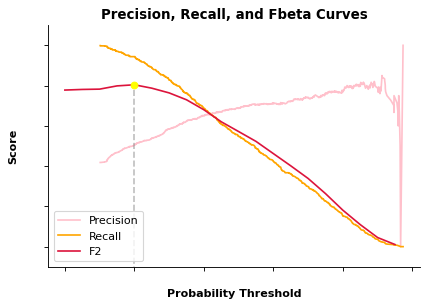

In [42]:
# Graph the Precision, Recall, and fbeta Curves
precision_curve, recall_curve, threshold_curve = precision_recall_curve(
    y_test,
    lg.predict_proba(X_test_scaled)[:, 1])

plt.figure(dpi=80)

plt.plot(threshold_curve, precision_curve[1:], label='Precision', color ='pink')
plt.plot(threshold_curve, recall_curve[1:], label='Recall', color ='orange')
plt.plot(list(zip(*fbeta_lg))[0], list(zip(*fbeta_lg))[1],label='F2', color ='crimson')
plt.plot([fbeta_best_lg[0], fbeta_best_lg[0]], [-1, fbeta_best_lg[1]],'--', color='gray',alpha=0.5)
plt.plot(fbeta_best_lg[0], fbeta_best_lg[1], 'o', color ='yellow')


plt.ylim([-0.1, 1.1])
plt.legend(loc='lower left')
plt.xlabel('Probability Threshold',fontweight="bold")
plt.ylabel('Score', fontweight="bold")
plt.title('Precision, Recall, and Fbeta Curves', fontweight="bold")
plt.xticks(color = 'white')
plt.yticks(color = 'white')
sns.despine()

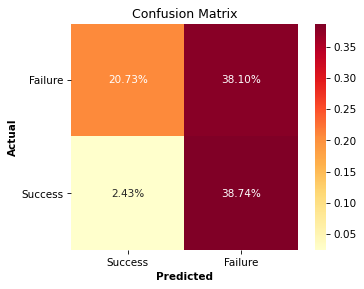

In [56]:
# Heatmap of the confusion matrix
confusion = confusion_matrix(y_test, pred)
cf = confusion/np.sum(confusion) 

plt.figure(dpi=75)
ax = sns.heatmap(cf, cmap='YlOrRd', annot=True, square=True, fmt='.2%',
                 xticklabels = ['Success','Failure'], yticklabels = ['Failure', 'Success'])
#bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Predicted', fontweight="bold")
plt.ylabel('Actual', fontweight="bold")
plt.title('Confusion Matrix')
#plt.title('Logistic Regression - confusion matrix')
plt.yticks(rotation=0)

plt.savefig('Images/Confusion Matrix.png');

In [43]:
# Plot the coefficients
lr_coefs = list(zip(X.columns, lg.coef_[0]))
lr_coefs_df = pd.DataFrame(lr_coefs)
lr_top_coefs = [x for x in lr_coefs if np.abs(x[1]) > .03]
lr_top_coefs = sorted(lr_top_coefs, key=(lambda x: x[1]))
lr_top_coefs_df = pd.DataFrame(lr_top_coefs)

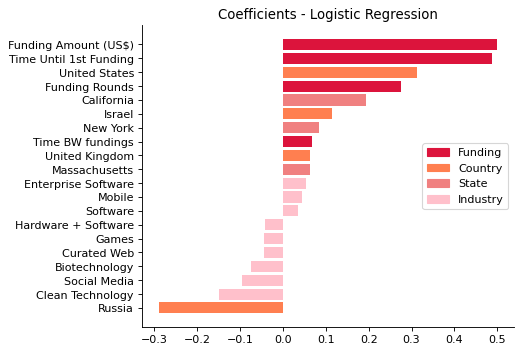

In [45]:
# Rename the features to read better
lr_top_coefs = [('Russia', -0.2893446545057915), ('Clean Technology', -0.14861353010039563),('Social Media', -0.09477211025363298),
                ('Biotechnology', -0.07399076324542722), ('Curated Web', -0.043942159802073125), ('Games', -0.04334392064509909),
                ('Hardware + Software', -0.04210937603562736), ('Software', 0.03596219484151503), ('Mobile', 0.04367677218985485),
                ('Enterprise Software', 0.05299427660288641), ('Massachusetts', 0.06272930045661039), ('United Kingdom', 0.06417162038580922),
                ('Time BW fundings', 0.06698581204378404), ('New York', 0.08325682304552291), ('Israel', 0.11344825072902413),
                ('California', 0.19473757793676166), ('Funding Rounds', 0.2755743382604995), ('United States', 0.31226725056819743),
                ('Time Until 1st Funding', 0.486862667851848),('Funding Amount (US$)', 0.4987495996762763)]



mycolor =['coral', 'pink', 'pink', 'pink', 'pink', 'pink', 'pink', 'pink', 'pink', 'pink', 
          'lightcoral', 'coral', 'crimson', 'lightcoral', 'coral', 'lightcoral', 'crimson', 'coral', 'crimson', 'crimson']

plt.figure(figsize = (6,5), dpi=80)
plt.barh([x[0] for x in lr_top_coefs], width=[x[1] for x in lr_top_coefs], color = mycolor)
plt.title('Coefficients - Logistic Regression')

patch1 = mpatches.Patch(color='crimson', label='Funding')
patch2 = mpatches.Patch(color='coral', label='Country')
patch3 = mpatches.Patch(color='lightcoral', label='State')
patch4 = mpatches.Patch(color='pink', label='Industry')
plt.legend(handles=[patch1, patch2, patch3, patch4], loc = 'center right')

plt.grid(b=False)
sns.despine()
plt.savefig('Images/Feature Importance.jpg', bbox_inches='tight')

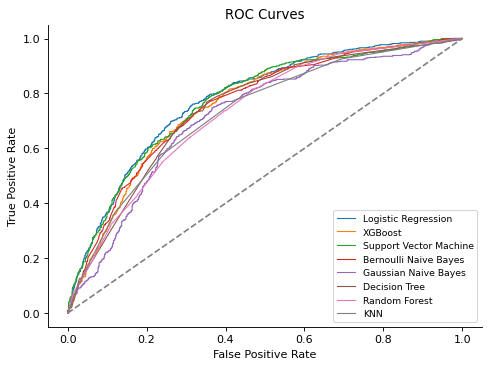

In [46]:
# Draw the ROC curve for all the models tested
plt.figure(figsize=(7,5), dpi=80)

plt.plot(fpr_lg, tpr_lg, lw=1, label ='Logistic Regression')
plt.plot(fpr_xgb, tpr_xgb, lw=1, label='XGBoost')
plt.plot(fpr_svc, tpr_svc, lw=1, label='Support Vector Machine')
plt.plot(fpr_nb, tpr_nb, lw=1, label='Bernoulli Naive Bayes' )
plt.plot(fpr_guass, tpr_guass, lw=1, label ='Gaussian Naive Bayes')
plt.plot(fpr_dt, tpr_dt, lw=1, label='Decision Tree')
plt.plot(fpr_rf, tpr_rf, lw=1, label='Random Forest')
plt.plot(fpr_knn, tpr_knn, lw=1, label='KNN')

plt.plot([0,1],[0,1],c='gray',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

sns.despine()
plt.legend(fontsize='small')
plt.xlabel('False Positive Rate') #, color = 'white',  fontweight="bold")
plt.ylabel('True Positive Rate') #, color = 'white',  fontweight="bold")
#plt.xticks(color = 'white')
#plt.yticks(color = 'white')
plt.title('ROC Curves') #, color = 'white',  fontweight="bold");
plt.savefig('Images/ROC Curves.jpg');

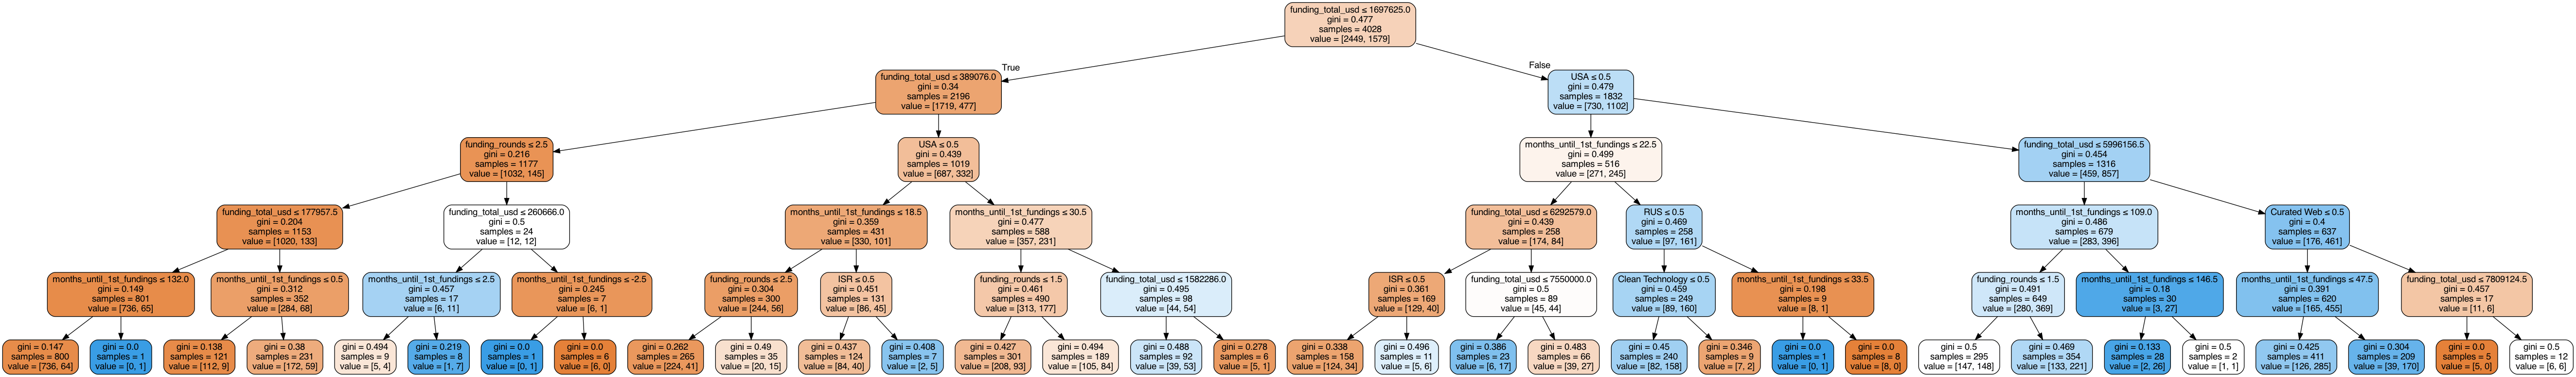

In [48]:
# Plot a sample decision tree
dot_data = StringIO()
export_graphviz(dt,
                out_file=dot_data,
                feature_names=X_train.columns.tolist(),
                filled=True,
                rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('Images//decision_tree.png')
Image(graph.create_png())